# Function definitions

In [1]:

using Distributions, StatsFuns, Random
using Plots, Colors

## make mixture plot
show_mixture(comps; xlim = [-6, 6], ylim = [0, 1]) = begin
    lwd = 2
    ns = [c.n for c in comps] 
    n = ns ./ sum(ns)
    p = plot(x -> pdf(MixtureModel(Normal[Normal(c.theta...) for c in comps],
                                   n), x), xlim[1] , xlim[2],
             framestyle=:box, legend = :none, linewidth = 3, color = :white, ylim = ylim)
    d = [Normal(c.theta[1], 1/sqrt(c.theta[2])) for c in comps]
    [plot!(x -> n[k] * pdf(d[k], x),
           params(d[k])[1] - minimum([abs(3.5 * params(d[k])[2]), 4]),
           params(d[k])[1] + minimum([abs(3.5 * params(d[k])[2]), 4]),
           xlim = (xlim[1], xlim[2]),
           linewidth = lwd, color = k)  for k in 1:length(d)]
    p
end

## MCMC inference for updating of parameters of component specific models
function do_mcmc(x, theta, target::Function, proposal::Function; n=1000) 
    vec=Array{typeof(theta), 1}(undef, n)
    ll = Array{Real, 1}(undef, n)
    vec[1] = theta
    ll[1]  = target(x, theta)  
    for i in 2:n
        mcmc_step!(i, vec, ll, x, target, proposal)
    end
    (theta = Array(hcat(vec...)'), ll = ll)
end
function mcmc_step!(i, vec, ll, x, target::Function, proposal::Function)
    can = proposal(vec[i-1])
    lik = target(x, can)
    if (rand() < exp(lik - ll[i-1])) 
        vec[i] = can
        ll[i]  = lik
    else
        vec[i] = vec[i-1]
        ll[i]  = ll[i-1]
    end
    return nothing
end

## compute predictive probabilities for label assingment
function predictive_prob(ynew, phi, j, comps, M)
    K = length(comps)
    n = sum([c.n for c in comps])
    ## compute assignment probabilities
    if j <= K
        log(comps[j].n / (n-1+M.alpha)) + logpdf(M.likelihood(phi[j]), ynew)
    else
        log((M.alpha/M.m) / (n-1+M.alpha)) + logpdf(M.likelihood(phi[j]), ynew)
    end
end


## do a first pass to initialize znew
function init_mixture(xnew, x, z, comps, M::NamedTuple)
    @assert length(x) == length(z)
    ##
    ## first pass to initialize znew
    ##
    nnew = length(xnew)
    znew = zeros(Int, nnew)
    alph = M.alpha[1]
    m = M.m
    n = nnew + sum([c.n for c in comps])
    for i in 1:nnew
        ## create canidates
        phi = [[c.theta for c in comps];
               [[rand(p) for p in M.prior] for rep in 1:m]]
        ps = [predictive_prob(xnew[i], phi, j, comps, M) for j in 1:length(phi)]
        ps .= exp.(ps .- logsumexp(ps))
        znew[i] = rand(Categorical(ps))
        if znew[i] > length(comps)
            ## create new components with the sampled parameters phi[z]
            push!(comps, (n = 1, theta = phi[znew[i]]))
            ## set to K+1
            znew[i] = length(comps) 
        else 
            n_iter = 10
            chn = do_mcmc([x[z.== znew[i]]; xnew[znew .== znew[i]]],
                          [comps[znew[i]].theta...], target(M), proposal, n = n_iter)
            theta_new = mean(chn.theta[round(Int, n_iter/2):end, :], dims = 1)
            comps[znew[i]] = (n = comps[znew[i]].n + 1, theta = theta_new)
        end
    end
    znew, comps
end

## do n_steps steps of Gibbs sampling
function update_mixture(x, z, comps, M; n_steps = 1)
    @assert length(x) == length(z)
    @assert length(x) == sum([c.n for c in comps])
    n = length(x)
    m = M.m
    alph = M.alpha[1]
    for iter in 1:n_steps
        @show iter
        # @show comps[1].n
        ## iterate over observations
        inds = shuffle(1:length(x))
        for i in inds
            ##
            ## create candidates
            ##
            ni = comps[z[i]].n
            if ni == 1
                ## if last element of a cluster,
                ## remove that cluster, but use phi
                ## in proposal (at position K^{-}+1)
                j = z[i]; oldcomp = comps[j]
                comps = comps[setdiff(1:length(comps), j)]
                ## fill gap in indices
                z[z .>= j] .= z[z .>= j] .- 1
                phi = [[comps[j].theta for j in 1:length(comps)];
                       [oldcomp.theta'];
                       [[rand(p) for p in M.prior] for rep in 1:m-1]]
            else
                comps[z[i]] = (n = comps[z[i]].n - 1,
                               theta = comps[z[i]].theta)
                phi = [[comps[j].theta for j in 1:length(comps)];
                       [[rand(p) for p in M.prior] for rep in 1:m]]
            end
            @assert length(phi) == length(comps) + m
            ps = [predictive_prob(x[i], phi, j, comps, M) for j in 1:length(phi)]
            ps .= exp.(ps .- logsumexp(ps))
            z[i] = rand(Categorical(ps))
            if z[i] >= length(comps)
                ## create new components with the sampled parameters phi[z]
                push!(comps, (n = 1, theta = phi[z[i]]))
                ## set to K+1
                z[i] = length(comps) 
            else 
                n_iter = 10
                chn = do_mcmc(x[z.== z[i]], [comps[z[i]].theta...], target(M),
                              proposal, n = n_iter)
                theta_new = mean(chn.theta[round(Int, n_iter/2):end, :], dims = 1)
                comps[z[i]] = (n = comps[z[i]].n + 1, theta = theta_new)
            end
            @assert maximum(z) <= length(comps)
        end
    end
    z, comps
end

## setup model M
function Model(;mm = 0.0, pm = .1, mp = 1, pp = .1, alpha = 1, m = 2)
    (likelihood = (theta) -> Normal(theta[1], 1/sqrt(theta[2])),
     prior = (prior_m = Normal(mm, 1/sqrt(pm)),
              prior_p = truncated(Normal(mp, 1/sqrt(pp)), 0, Inf)),
     alpha = alpha,
     m = m)
end


Model (generic function with 1 method)

# Figure 1

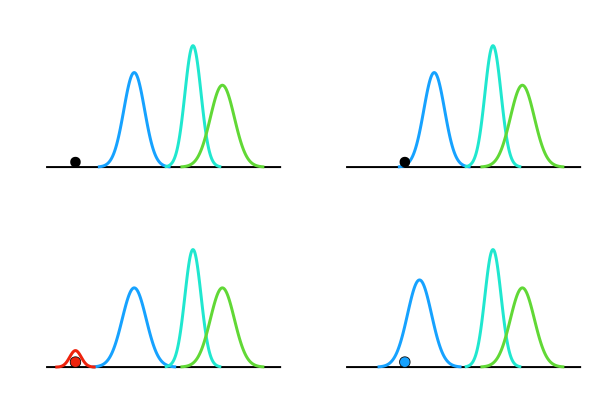

In [2]:
###
### Concept of inference in mixture
###

## rgb values for keynote colors
my_cols = [(red = 22, green = 162, blue = 255),
           (red = 32, green = 231, blue = 207),
           (red = 97, green = 216, blue = 54),
           (red = 238,green =  34, blue = 12),
           (red = 239,green =  95, blue = 167)]
my_cols = [RGB([ai / 255 for ai in a]...) for a in my_cols]
my_cols = [my_cols; Colors.distinguishable_colors(6)]

function plot_comps(comps, ynew, colnew)
    xlim = [-8, 8]
    ylim = [0, .3]
    lwd = 3
    n = [c.n for c in comps]
    n = n ./ sum(n)
    p = plot(x -> pdf(MixtureModel(Normal[Normal(c.theta...) for c in comps],
                                   n), x), xlim[1] , xlim[2],
             framestyle=:none, legend = :none, linewidth = 3, color = :white,
             xlim = xlim, ylim = ylim)
    plot!(p, xlim, [0, 0], color = :black, linewidth=2)
    d = [Normal(c.theta[1], 1/sqrt(c.theta[2])) for c in comps]
    [plot!(p, x -> n[k] * pdf(d[k], x),
           params(d[k])[1] - 3.5 * params(d[k])[2],
           params(d[k])[1] + 3.5 * params(d[k])[2],
           linewidth = lwd, color = my_cols[k])  for k in 1:length(d)]
    scatter!(p, [ynew], repeat([.01], length(ynew)), color = colnew, markersize = 6,
             linewidth = lwd)
    p
end
## initial theta
comps1 = [(n = 20, theta = [-2.0, 2.0]),
          (n = 20, theta = [2.0 3.3]),
          (n = 20, theta = [4.0 1.5])]
## integration:  x -4
comps2 = [(n = 22, theta = [-3.0 1.5]),
          (n = 20, theta = [2.0 3.3]),
          (n = 20, theta = [4.0 1.5])]
## outlier: 
comps3 = [(n = 20, theta = [-2.0, 1.5]),
          (n = 20, theta = [2.0 3.3]),
          (n = 20, theta = [4.0 1.5]),
          (n = 2, theta = [-6.0 6.5])]
plot(plot_comps(comps1, -6, :black),
     plot_comps(comps1, -4, :black),
     plot_comps(comps3, -6, my_cols[4]),
     plot_comps(comps2, -4, my_cols[1]))


# Figure 2

phi = [[0.0, 0.5], [1.5823636787339215, 2.974744070179984], [6.252774517023994, 1.1621133309173732]]
phi = [[0.0, 0.5], [-0.37892441398610693, 5.268983255279999], [-3.9822796188877656, 1.4204904331653208]]


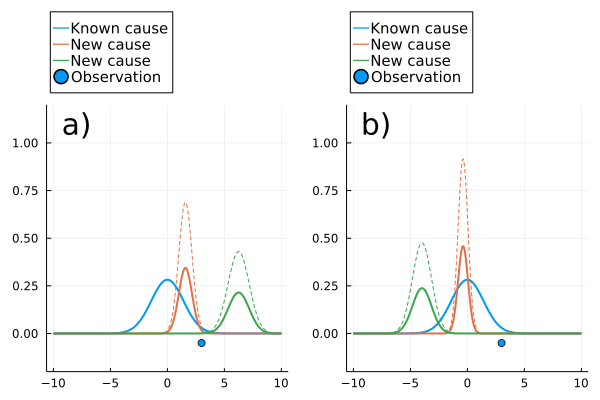

In [11]:

Random.seed!(127)
plots = []
ylim = (-.2, 1.2)
for rep in 1:2
    ## define a component
    comps = [(n = 1, theta = [0.0, .5])]
    ## predict label for data
    ynew = 3.0
    # create canidates
    M = Model(m = 2, alpha = 1)
    phi = [[c.theta for c in comps];
        [[rand(p) for p in M.prior] for rep in 1:M.m]]
    @show phi
    ## setup model
    ps = [predictive_prob(ynew, phi, j, comps, M) for j in 1:length(phi)]
    ps .= exp.(ps .- logsumexp(ps))
    z = rand(Categorical(ps))
    z = findmax(ps)[2]
    ## show proposals
    p = plot([y-> pdf(M.likelihood(phi[j]), y) for j in 1:length(phi)], -10, 10, 
        ylim = ylim, 
        line = (1, :dash),
        lab = ["Known cause" "New cause" "New cause"], 
        annotations = (-8, 1.1, Plots.text("$(["a","b"][length(plots)+1]))", :center, :bold, 20)),
        legend= rep<3 ? :none : :outertop, legendfontsize = 5)
    plot!([y -> exp(predictive_prob(y, phi, j, comps, M)) for j in 1:length(phi)],
              -10, 10, linewidth = 2, color = [1 2 3],
              lab = false)
    ## and predicted label
    scatter!(p, [ynew], [-0.05], color = z, lab = "Observation")
    push!(plots, p)
end
plot(plots..., 
     lab = ["" "" "" "Known cause" "New cause" "New cause" "Observation"], 
     legend= :outertop, legendfontsize = 10)


# Figure 3

iter = 1
iter = 2
iter = 3
iter = 4
iter = 5
iter = 6
iter = 7
iter = 8
iter = 9
iter = 10
iter = 1
iter = 2
iter = 3
iter = 4
iter = 5
iter = 6
iter = 7
iter = 8
iter = 9
iter = 10


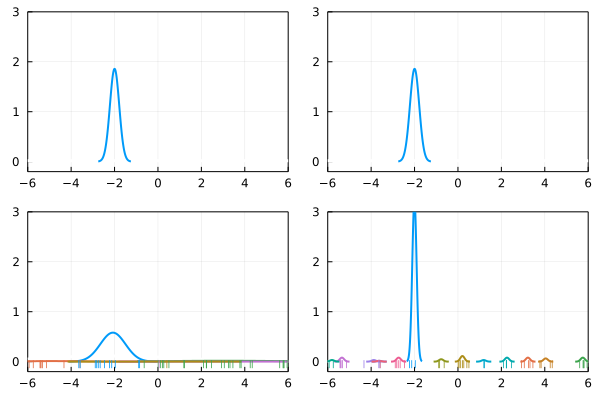

In [8]:

## define prior and posterior for component parameter updates
prior(m::Real, p::Real, M::NamedTuple) = logpdf(M.prior.prior_m, m) +
    logpdf(truncated(M.prior.prior_p, 0, Inf), p)
target(M) = (x, theta) -> sum(logpdf.(Normal(theta[1], 1/sqrt(theta[2])), x)) + prior(theta..., M)
proposal(theta) = [rand(Normal(theta[1], 1)), rand(truncated(Normal(theta[2], 1), 0, Inf))]
## setup models
M1 = Model(pm = 0.01, mp = 1/100, pp = 10, alpha = 1)
M2 = Model(pm = 0.01, mp =  100, pp = 10, alpha = 1)
n_steps = 10
ylim = (-0.2, 3.0)
nnew = 50
plots = []
results = []
# start simulations from same seed
seed = 9369
for M in [M1, M2]
    Random.seed!(seed);
    ## make initial clusters
    m = [-2]
    nk = [200]
    xinit = vcat([m[k] .+ randn(nk[k]) * .1 for k in 1:length(m)]...)
    zinit = vcat([repeat([j], nk[j]) for j in 1:length(m)]...)
    comps_init = []
    for k in 1:length(m)
        n_iter = 1000
        chn = do_mcmc(xinit[zinit.==k], ones(2), target(Model()), proposal, n = n_iter)
        theta = mean(chn.theta[round(Int, n_iter/2):end, :], dims = 1)
        push!(comps_init, (n=nk[k], theta = theta))
    end
    comps = deepcopy(comps_init)
    p1 = show_mixture(comps_init, ylim = ylim)
    push!(plots, p1)
    ## new data
    xnew = rand(Uniform(-6, 6), nnew)
    ## init 
    znew, comps = init_mixture(xnew, xinit, zinit, deepcopy(comps_init), M)
    x = [xinit; xnew]; z = [zinit; znew]
    ## consolidate
    z, comps = update_mixture(x, z, comps, M; n_steps = n_steps)
    p2 = show_mixture(comps, ylim = ylim)
    scatter!(p2, [xnew...], repeat([-0.051], length(xnew)),
             color = z[nk[1]+1:end], m = :vline, linewidth = 3)
    push!(plots, p2)
    push!(results, [deepcopy(x), deepcopy(z), deepcopy(comps)])
end
plot(plots[1], plots[3], plots[2], plots[4])
